# Conducción estacionaria

**Trabajo realizado con el apoyo del Programa UNAM-DGAPA-PAPIME PE101019**

- Autor: Luis M. de la Cruz Salas
- Rev: mié 24 feb 2021 14:41:27 CST

In [1]:
# Celda 1
import numpy as np
import matplotlib.pyplot as plt
import macti.visual as mvis

# Parámetros para el estilo de las gráficas
params = {'figure.figsize' : (14,7),
          'text.usetex'    : True,
          'xtick.labelsize': 20,
          'ytick.labelsize': 20,
          'axes.labelsize' : 24,
          'axes.titlesize' : 24,
          'legend.fontsize': 24,
          'lines.linewidth': 3,
          'lines.markersize': 10,
          'grid.color'     : 'darkgray',
          'grid.linewidth' : 0.5,
          'grid.linestyle' : '--',
          'font.family': 'DejaVu Serif',
         }
plt.rcParams['axes.grid'] = False
plt.rcParams.update(params)

In [2]:
# Celda 2
def buildMatrix(N, d):
    '''
    Parameters:
    N: int Tamaño de la matriz.
    d: float Contenido de la diagonal.
    '''
    # Matriz de ceros
    A = np.zeros((N,N))
    
    # Primer renglón
    A[0,0] = d
    A[0,1] = -1
    
    # Renglones interiores
    for i in range(1,N-1):
        A[i,i] = d
        A[i,i+1] = -1
        A[i,i-1] = -1
    
    # Último renglón
    A[N-1,N-2] = -1
    A[N-1,N-1] = d
    
    return A

In [3]:
# Celda 3
# Parámetros físicos
L = 1.0
f_A = 0.0  # Flujo en A (Neumman)
b_B = 3.0  # Valor de u en B (Dirichlet)
k = 1.0

# Parámetros numéricos
N = 4 # Número de incógnitas
h = L / (N+1)

In [4]:
# Celda 4
def condNeumman_I(A, b, bcond):
    A[0][0] = 1
    A[0][1] = -1
    A[0][2] = 0
    b[0] = bcond

def condNeumman_II(A, b, bcond):
    A[0][0] = 3
    A[0][1] = -4
    A[0][2] = 1
    b[0] = bcond

def condNeumman_III(A, b, bcond):
    A[0][0] = 2
    A[0][1] = -2
    A[0][2] = 0
    b[0] = bcond

In [5]:
# Celda 5
def solExact(x):
    return np.exp(x) - x - np.e + 4

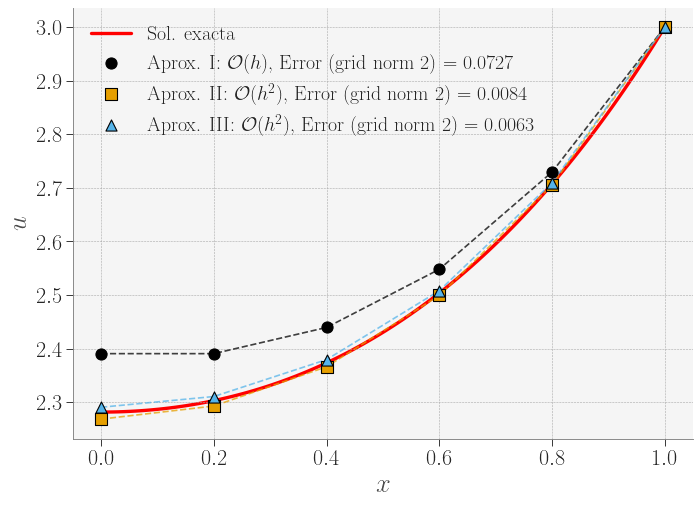

In [7]:
# Celda 6
# Coordenadas de los nodos
x = np.linspace(0, L, N+2)

sole = solExact(x) # Solución exacta en los nodos

A = buildMatrix(N+1, 2)      # Construcción de la matriz
b = np.zeros(N+1)            # Lado derecho del sistema
b[1:] = -np.exp(x[1:-1])*h**2 # Fuente o sumidero
b[-1] += b_B                 # Condición de frontera en B

# Solución con la aproximación I: orden lineal
condNeumman_I(A, b, h * f_A) # Corrección de la matriz y el RHS
u1 = np.zeros(N+2) # Arreglo para almacenar la solución
u1[-1] = b_B       # Frontera derecha Dirichlet
u1[:N+1] = np.linalg.solve(A,b)       # Sol. del sist. lineal
e1 = np.sqrt(h) * np.linalg.norm(sole - u1, 2) # Cálculo del error

# Solución con la aproximación II: orden cuadrático (tres puntos)
condNeumman_II(A, b, 2 * h * f_A) # Corrección de la matriz y el RHS
u2 = np.zeros(N+2) # Arreglo para almacenar la solución
u2[-1] = b_B       # Frontera derecha Dirichlet
u2[:N+1] = np.linalg.solve(A,b)       # Sol. del sist. lineal
e2 = np.sqrt(h) * np.linalg.norm(sole - u2, 2) # Cálculo del error

# Solución con la aproximación III: orden cuadrático (centrales)
condNeumman_III(A, b, -np.exp(x[0]) * h**2 + 2 * h * f_A) # Corrección de la matriz y el RHS
u3 = np.zeros(N+2) # Arreglo para almacenar la solución
u3[-1] = b_B       # Frontera derecha Dirichlet
u3[:N+1] = np.linalg.solve(A,b)       # Sol. del sist. lineal
e3 = np.sqrt(h) * np.linalg.norm(sole - u3, 2) # Cálculo del error

# Impresión y graficación de la solución
plt.figure(figsize=(10,7))
xsol = np.linspace(0,1,100)
error_label_1 = 'Error (grid norm {}) = {:0.4f}'.format(2, e1)
error_label_2 = 'Error (grid norm {}) = {:0.4f}'.format(2, e2)
error_label_3 = 'Error (grid norm {}) = {:0.4f}'.format(2, e3)
plt.plot(xsol, solExact(xsol),'r-', label='Sol. exacta', zorder=0)
plt.scatter(x, u1, marker='o', edgecolor='k', zorder=5,
            label='Aprox. I: $\mathcal{O}(h)$, ' + error_label_1)
plt.plot(x, u1, '--', lw=1.5, alpha=0.75)
plt.scatter(x, u2, marker='s', edgecolor='k', zorder=5,
            label='Aprox. II: $\mathcal{O}(h^2)$, ' + error_label_2)
plt.plot(x, u2, '--', lw=1.5, alpha=0.75)
plt.scatter(x, u3, marker='^', edgecolor='k', zorder=5,
            label='Aprox. III: $\mathcal{O}(h^2)$, ' + error_label_3)
plt.plot(x, u3, '--', lw=1.5, alpha=0.75)
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.legend(loc='upper left', fontsize=18)
plt.grid()
plt.savefig('calibracion2.pdf')
plt.show()

In [8]:
# Celda 7
def meshRefining(fcondNeumman, nodos, norma):
    """
    Función que permite realizar un estudio de
    refinamiento de malla.
    
    Parameters:
    -----------
    fcondNeumman: function
    función que establece la aproximación para la condición 
    de frontera de tipo Neumman.
    
    nodes: list
    Lista de número de nodos que se usarán para el estudio
    de refinamiento de malla.
    
    norma: 
    Define el tipo de grid norm que se usará para calcular el 
    error con respecto a la solución exacta.
    
    Returns:
    --------
    e_lista: list
    Lista con los errores calculados para los diferentes números
    de nodos.
    """
    e_lista = []
    for N in nodos:
        h = L / (N+1)        
        r = k / h**2

        # Coordenadas de los nodos
        x = np.linspace(0, L, N+2)

        sole = solExact(x)

        A = buildMatrix(N+1, 2)      # Construcción de la matriz
        b = np.zeros(N+1)            # Lado derecho del sistema
        b[1:] = -np.exp(x[1:-1]) / r # Fuente o sumidero
        b[-1] += b_B                 # Condición de frontera en B

        if fcondNeumman.__name__ == 'condNeumman_I':
            bcond = h * f_A
        elif fcondNeumman.__name__ == 'condNeumman_II':
            bcond = 2 * h * f_A
        elif fcondNeumman.__name__ == 'condNeumman_III':
            bcond = -0.5/r + h * f_A

        fcondNeumman(A, b, bcond) # Corrección de la matriz y el RHS

        # Solución con la aproximación III: orden cuadrático (centrales)
        u = np.zeros(N+2) # Arreglo para almacenar la solución
        u[-1] = b_B       # Frontera derecha Dirichlet
        u[:N+1] = np.linalg.solve(A,b)       # Sol. del sist. lineal
        e_lista.append(np.linalg.norm(sole - u, norma)) # Cálculo del error

    return e_lista


In [9]:
# Celda 8
### BEGIN SOLUTION
nodos = [2**i for i in range(2,8)]
h_lista = [L/(n+1) for n in nodos]

norma = np.inf

e1m = meshRefining(condNeumman_I, nodos, norma)
e2m = meshRefining(condNeumman_II, nodos, norma)
e3m = meshRefining(condNeumman_III, nodos, norma)
### END SOLUTION

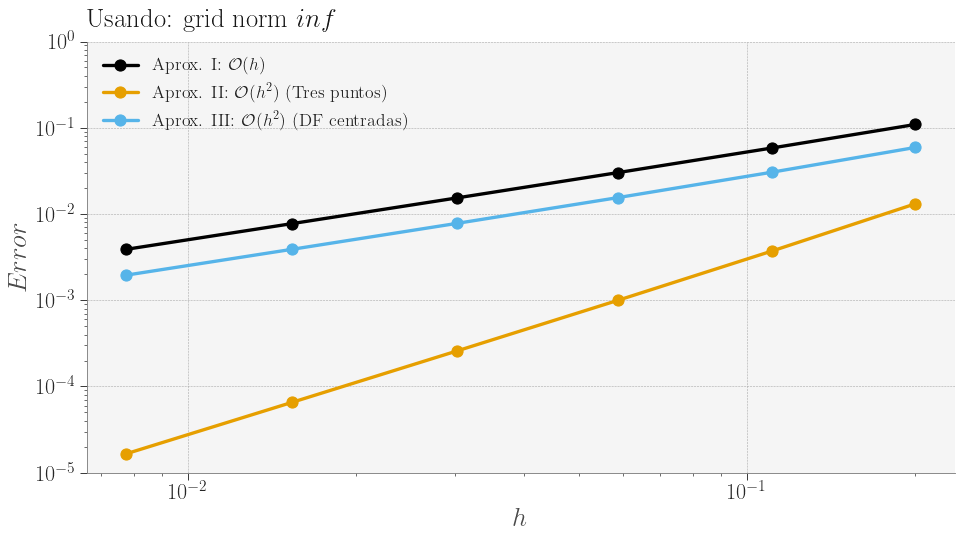

In [10]:
#
# El siguiente código genera las gráficas usando los resultados anteriores:
#
plt.plot(h_lista, e1m, 'o-', label='Aprox. I: $\mathcal{O}(h)$')
plt.plot(h_lista, e2m, 'o-', label='Aprox. II: $\mathcal{O}(h^2)$ (Tres puntos)')
plt.plot(h_lista, e3m, 'o-', label='Aprox. III: $\mathcal{O}(h^2)$ (DF centradas)')
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=16)
plt.ylim(1e-5,1)
plt.ylabel('$Error$')
plt.xlabel('$h$')
plt.title('Usando: grid norm ${}$'.format(norma))
plt.grid()
plt.show()